In [1]:
import pandas as pd
import numpy as np
from pandas import datetime
from matplotlib import pyplot as plt
import os

from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot

#from pyramid.arima import auto_arima
#from pmdarima.arima import auto_arima
#import pyflux as pf
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import SimpleRNN
from keras.layers import Conv1D

import time

In [6]:
plt.rcParams.update({'font.size': 22})
pd.set_option("display.max_columns", 4)

In [7]:
file_path = "../Data_acquisition/Final DB/household/"

In [8]:
df = pd.read_csv(file_path + "merged_energy.csv")
df.head()

,day,energy_sum,Count,avg_energy
0,2011-11-23,90.385000,13,6.952692
1,2011-11-24,213.412000,25,8.536480
2,2011-11-25,303.993000,32,9.499781
3,2011-11-26,420.976000,41,10.267707
4,2011-11-27,444.883001,41,10.850805


In [9]:
len(df)

828

In [10]:
# Weather information
weather = pd.read_csv(file_path + "merged_weather.csv")
weather.head(4)

,temperatureMax,temperatureMaxTime,...,apparentTemperatureLowTime,moonPhase
0,11.96,2011-11-11 23:00:00,...,2011-11-11 19:00:00,0.52
1,8.59,2011-12-11 14:00:00,...,2011-12-12 08:00:00,0.53
2,10.33,2011-12-27 02:00:00,...,2011-12-28 00:00:00,0.10
3,8.07,2011-12-02 23:00:00,...,2011-12-02 19:00:00,0.25


In [11]:
weather.describe()

,temperatureMax,windBearing,...,apparentTemperatureMin,moonPhase
count,882.000000,882.000000,...,882.000000,882.000000
mean,13.660113,195.702948,...,5.738039,0.500930
std,6.182744,89.340783,...,6.048746,0.287022
min,-0.060000,0.000000,...,-8.880000,0.000000
25%,9.502500,120.500000,...,1.105000,0.260000
50%,12.625000,219.000000,...,4.885000,0.500000
75%,17.920000,255.000000,...,11.277500,0.750000
max,32.400000,359.000000,...,20.540000,0.990000


In [12]:
weather["day"]=  pd.to_datetime(weather["time"]) # day is given as timestamp
weather["day"]=  pd.to_datetime(weather["day"],format="%Y%m%d").dt.date
# selecting numeric variables
weather = weather[['temperatureMax', 'windBearing', 'dewPoint', 'cloudCover', 'windSpeed',
       'pressure', 'apparentTemperatureHigh', 'visibility', 'humidity',
       'apparentTemperatureLow', 'apparentTemperatureMax', 'uvIndex',
       'temperatureLow', 'temperatureMin', 'temperatureHigh',
       'apparentTemperatureMin', 'moonPhase','day']]
weather = weather.dropna()

In [13]:
#convert column day in df into datetime
df["day"] = pd.to_datetime(df["day"],format="%Y-%m-%d").dt.date
df.head()

,day,energy_sum,Count,avg_energy
0,2011-11-23,90.385000,13,6.952692
1,2011-11-24,213.412000,25,8.536480
2,2011-11-25,303.993000,32,9.499781
3,2011-11-26,420.976000,41,10.267707
4,2011-11-27,444.883001,41,10.850805


In [14]:
type(df.day[0])

datetime.date

In [15]:
merged_df = df.merge(weather,on='day')
merged_df.head()

,day,energy_sum,...,apparentTemperatureMin,moonPhase
0,2011-11-23,90.385000,...,2.18,0.94
1,2011-11-24,213.412000,...,7.01,0.97
2,2011-11-25,303.993000,...,4.84,0.01
3,2011-11-26,420.976000,...,4.69,0.05
4,2011-11-27,444.883001,...,2.94,0.08


In [16]:
#creating clusters

In [17]:
#scaling
scaler = MinMaxScaler()
weather_scaled = scaler.fit_transform(merged_df[["temperatureMax","humidity","windSpeed"]])

In [18]:
# optimum K
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans

score = [kmeans[i].fit(weather_scaled).score(weather_scaled) for i in range(len(kmeans))]
score


[-81.30483788002147,
 -52.912191794045405,
 -38.969162229636055,
 -33.222630046623856,
 -29.052749913698708,
 -25.59804735272027,
 -23.108403138977767,
 -20.994430033072174,
 -19.608167559734188,
 -18.358428490254532,
 -16.965738379843177,
 -16.094812953269948,
 -15.309705200056726,
 -14.483370469342374,
 -13.824643260338824,
 -13.154304622719563,
 -12.702224725990822,
 -12.256055650412623,
 -11.65356094550873]

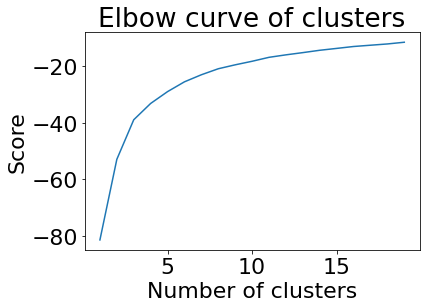

In [19]:
plt.plot(Nc,score)
plt.xlabel("Number of clusters")
plt.ylabel("Score")
plt.title("Elbow curve of clusters")
plt.show()

In [20]:
kmeans = KMeans(n_clusters=3, max_iter=400, algorithm = "auto")
kmeans.fit(weather_scaled)
merged_df["weather_cluster"] = kmeans.labels_

In [21]:
merged_df.head()

,day,energy_sum,...,moonPhase,weather_cluster
0,2011-11-23,90.385000,...,0.94,2
1,2011-11-24,213.412000,...,0.97,2
2,2011-11-25,303.993000,...,0.01,1
3,2011-11-26,420.976000,...,0.05,1
4,2011-11-27,444.883001,...,0.08,1


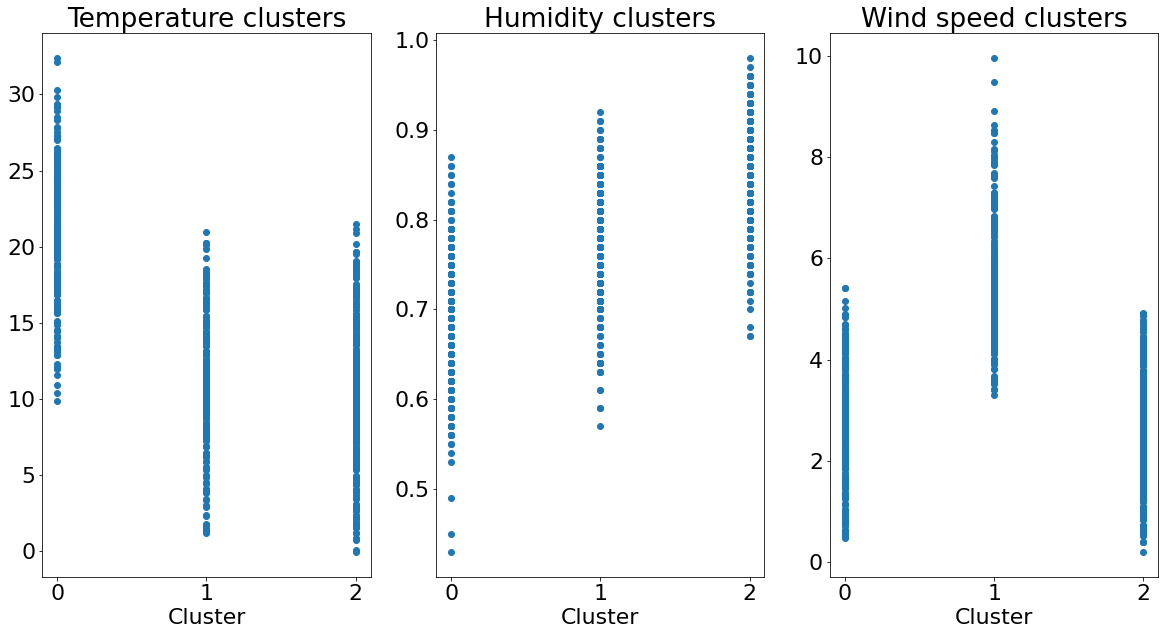

In [22]:
# Cluster Relationships with weather variables
plt.figure(figsize=(20,10))
plt.subplot(1, 3, 1)
plt.scatter(merged_df.weather_cluster,merged_df.temperatureMax)
plt.title("Temperature clusters")
plt.xlabel("Cluster")
plt.subplot(1, 3, 2)
plt.scatter(merged_df.weather_cluster,merged_df.humidity)
plt.title("Humidity clusters")
plt.xlabel("Cluster")
plt.subplot(1, 3, 3)
plt.scatter(merged_df.weather_cluster,merged_df.windSpeed)
plt.title("Wind speed clusters")
plt.xlabel("Cluster")
plt.show()
# put this in a loop

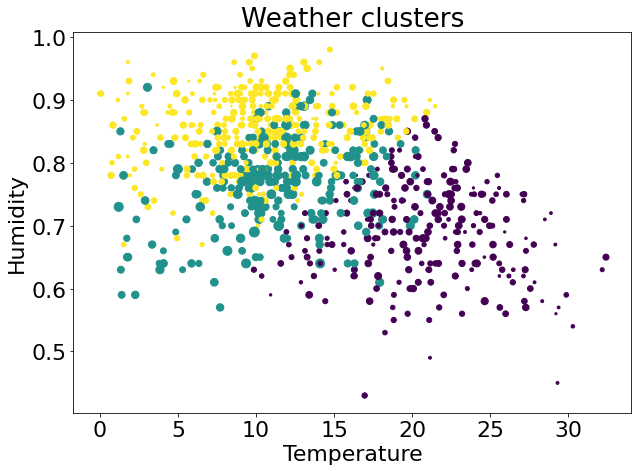

In [85]:
fig, ax1 = plt.subplots(figsize = (10,7))
ax1.scatter(merged_df.temperatureMax, 
            merged_df.humidity, 
            s = merged_df.windSpeed*10,
            c = merged_df.weather_cluster)
ax1.set_xlabel("Temperature")
ax1.set_ylabel("Humidity")
ax1.set_title("Weather clusters")
plt.show()

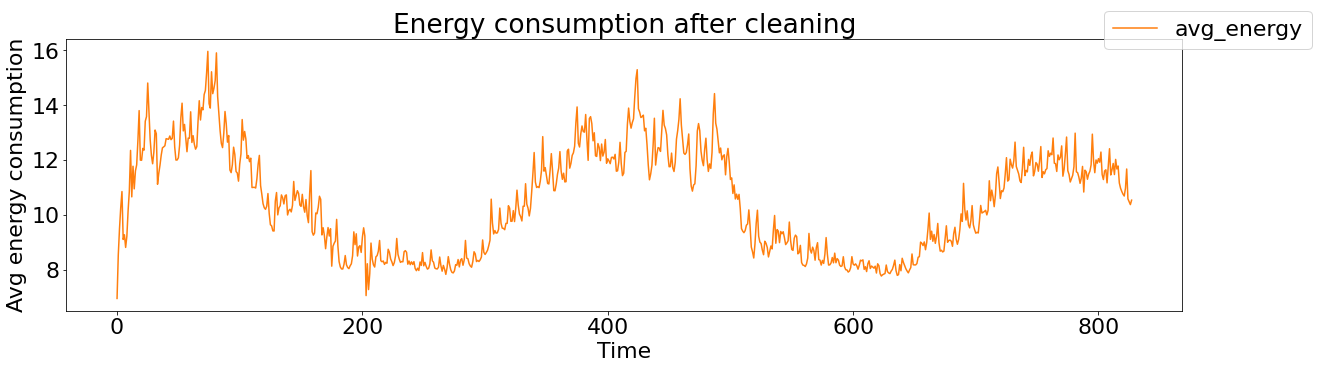

In [24]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(np.arange(len(df.avg_energy)), df.avg_energy, color = "tab:orange", label = "avg_energy")
#ax1.set_ylim([-5,80])
ax1.set_title("Energy consumption after cleaning")
ax1.set_ylabel("Avg energy consumption")
ax1.set_xlabel("Time")
fig.legend(loc="upper right")

In [25]:
holiday = pd.read_csv(file_path + "holidays.csv")
holiday["Bank holidays"] = pd.to_datetime(holiday["Bank holidays"],format="%Y-%m-%d").dt.date
holiday

,Bank holidays,Type
0,2012-12-26,Boxing Day
1,2012-12-25,Christmas Day
2,2012-08-27,Summer bank holiday
3,2012-05-06,Queen?s Diamond Jubilee (extra bank holiday)
4,2012-04-06,Spring bank holiday (substitute day)
5,2012-07-05,Early May bank holiday
6,2012-09-04,Easter Monday
7,2012-06-04,Good Friday
8,2012-02-01,New Year?s Day (substitute day)
9,2013-12-26,Boxing Day


In [26]:
#encoding holiday to 1, and normal day to 0

In [27]:
merged_df = merged_df.merge(holiday, left_on = "day",right_on = "Bank holidays",how = "left")
merged_df["holiday_ind"] = np.where(merged_df["Bank holidays"].isna(),0,1)

In [28]:
sum(merged_df["Bank holidays"].isna())

810

In [29]:
sum(merged_df["Type"].isna())

810

In [30]:
sum(merged_df["holiday_ind"])

17

In [31]:
len(merged_df)

827

In [32]:
merged_df.columns

Index(['day', 'energy_sum', 'Count', 'avg_energy', 'temperatureMax',
       'windBearing', 'dewPoint', 'cloudCover', 'windSpeed', 'pressure',
       'apparentTemperatureHigh', 'visibility', 'humidity',
       'apparentTemperatureLow', 'apparentTemperatureMax', 'uvIndex',
       'temperatureLow', 'temperatureMin', 'temperatureHigh',
       'apparentTemperatureMin', 'moonPhase', 'weather_cluster',
       'Bank holidays', 'Type', 'holiday_ind'],
      dtype='object')

In [33]:
merged_df['Year'] = pd.DatetimeIndex(merged_df['day']).year  
merged_df['Month'] = pd.DatetimeIndex(merged_df['day']).month
merged_df.set_index(['day'],inplace=True)

In [34]:
merged_df

,energy_sum,Count,...,Year,Month
day,,,,,
2011-11-23,90.385000,13,...,2011,11
2011-11-24,213.412000,25,...,2011,11
2011-11-25,303.993000,32,...,2011,11
2011-11-26,420.976000,41,...,2011,11
2011-11-27,444.883001,41,...,2011,11
...,...,...,...,...,...
2014-02-23,58345.432995,4998,...,2014,2
2014-02-24,52867.660004,4994,...,2014,2
2014-02-25,52330.109999,4995,...,2014,2


In [35]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

In [36]:
def windowed_dataset2(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [37]:
np.random.seed(51)
dataframe = merged_df.loc[:,'avg_energy']
dataset = dataframe.values
dataset = dataset.astype('float32')

In [38]:
reframed = windowed_dataset2(dataset, 7,1)
reframed.head(3)

,var1(t-7),var1(t-6),...,var1(t-1),var1(t)
7,6.952693,8.536480,...,9.274873,8.813513
8,8.536480,9.499782,...,8.813513,9.227707
9,9.499782,10.267707,...,9.227707,10.145910


In [39]:
reframed["weather_cluster"] = merged_df.weather_cluster.values[7:]
reframed['holiday_ind']= merged_df.holiday_ind.values[7:]

In [40]:
reframed.head()

,var1(t-7),var1(t-6),...,weather_cluster,holiday_ind
7,6.952693,8.536480,...,1,0
8,8.536480,9.499782,...,2,0
9,9.499782,10.267707,...,2,0
10,10.267707,10.850805,...,1,0
11,10.850805,9.103382,...,1,0


In [41]:
reframed = reframed.reindex(['weather_cluster', 'holiday_ind','var1(t-7)', 'var1(t-6)', 'var1(t-5)', 'var1(t-4)', 'var1(t-3)','var1(t-2)', 'var1(t-1)', 'var1(t)'], axis=1)
reframed = reframed.values

In [42]:
scaler = MinMaxScaler(feature_range=(0, 1))
reframed = scaler.fit_transform(reframed)

In [43]:
# split into train and test sets
#train test split 70-30
time_split = int(len(merged_df)*0.7)
train = reframed[:time_split, :]
test = reframed[time_split:, :]

In [44]:
train_X, train_y = train[:, :-1], train[:,-1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape,test_X.shape)

(578, 9) (242, 9)


In [45]:
# reshape input to be 3D [samples, timesteps, features]
train_X_copy = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X_copy = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
train_y_copy = train_y
test_y_copy = test_y
print(train_X_copy.shape,train_X.shape, train_y.shape, test_X_copy.shape, test_X.shape, test_y.shape)

(578, 1, 9) (578, 9) (578,) (242, 1, 9) (242, 9) (242,)


Epoch 151/400
6/6 [==============================] - 0s 2ms/step - loss: 0.0390
Epoch 152/400
6/6 [==============================] - 0s 2ms/step - loss: 0.0385
Epoch 153/400
6/6 [==============================] - 0s 2ms/step - loss: 0.0381
Epoch 154/400
6/6 [==============================] - 0s 2ms/step - loss: 0.0393
Epoch 155/400
6/6 [==============================] - 0s 2ms/step - loss: 0.0393
Epoch 156/400
6/6 [==============================] - 0s 2ms/step - loss: 0.0382
Epoch 157/400
6/6 [==============================] - 0s 2ms/step - loss: 0.0394
Epoch 158/400
6/6 [==============================] - 0s 2ms/step - loss: 0.0392
Epoch 159/400
6/6 [==============================] - 0s 2ms/step - loss: 0.0382
Epoch 160/400
6/6 [==============================] - 0s 2ms/step - loss: 0.0387
Epoch 161/400
6/6 [==============================] - 0s 2ms/step - loss: 0.0387
Epoch 162/400
6/6 [==============================] - 0s 2ms/step - loss: 0.0379
Epoch 163/400
6/6 [=====================

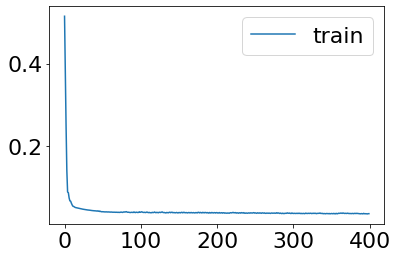

8.360474109649658


In [46]:
#1-layer RNN
start = time.time()

model = Sequential([
    SimpleRNN(30, input_shape=(train_X_copy.shape[1], train_X_copy.shape[2])),
    Dense(30, activation = "relu"),
    Dense(15, activation = "relu"),
    Dense(1)
])

model.compile(loss="mae", optimizer="adam")
history = model.fit(train_X_copy, train_y, epochs=400, batch_size=100, verbose=1, shuffle=False)
# plot history
pyplot.plot(history.history["loss"], label="train")
pyplot.legend()
pyplot.show()

print(time.time()-start)

In [47]:
# make a prediction
start = time.time()

yhat = model.predict(test_X_copy)
test_X_copy = test_X_copy.reshape(test_X_copy.shape[0], test_X_copy.shape[2])

print(time.time()-start)

0.21152806282043457


In [48]:
# invert scaling for forecast
inv_yhat = np.concatenate((test_X_copy,yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)

In [49]:
# invert scaling for actual
test_y_copy = test_y_copy.reshape((len(test_y_copy), 1))
inv_y = np.concatenate((test_X_copy,test_y_copy), axis=1)
inv_y = scaler.inverse_transform(inv_y)

In [50]:
# last element
act = [i[9] for i in inv_y] 
pred = [i[9] for i in inv_yhat] 

#Calculate MAE
print(mean_squared_error(act,pred))
print(mean_absolute_percentage_error(np.array(act),np.array(pred)))

0.16572800207480176
2.881400047484086


In [51]:
time_valid = np.arange(len(pred))
len(time_valid)

242

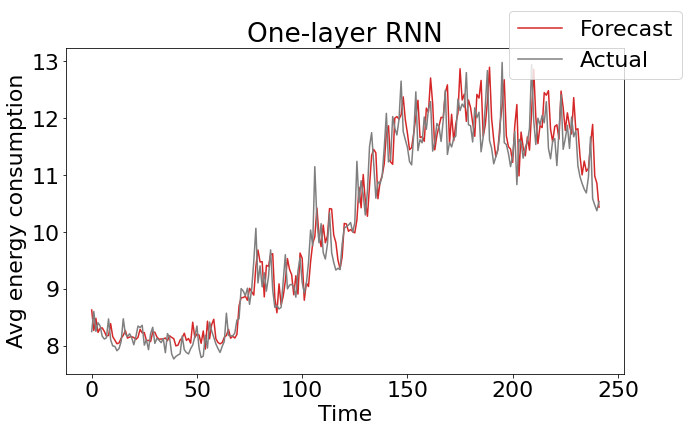

In [52]:
fig, ax1 = plt.subplots(figsize = (10,6))
ax1.plot(time_valid, pred, color = "tab:red", label = "Forecast")
ax1.plot(time_valid, act, color = "tab:grey", label = "Actual")
#ax1.set_ylim([-5,80])
ax1.set_title("One-layer RNN")
ax1.set_ylabel("Avg energy consumption")
ax1.set_xlabel("Time")
fig.legend(loc="upper right")

In [53]:
# reshape input to be 3D [samples, timesteps, features]
train_X_copy = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X_copy = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
train_y_copy = train_y
test_y_copy = test_y
print(train_X_copy.shape,train_X.shape, train_y.shape, test_X_copy.shape, test_X.shape, test_y.shape)

(578, 1, 9) (578, 9) (578,) (242, 1, 9) (242, 9) (242,)


Epoch 151/400
6/6 [==============================] - 0s 4ms/step - loss: 0.0374
Epoch 152/400
6/6 [==============================] - 0s 3ms/step - loss: 0.0372
Epoch 153/400
6/6 [==============================] - 0s 3ms/step - loss: 0.0370
Epoch 154/400
6/6 [==============================] - 0s 4ms/step - loss: 0.0370
Epoch 155/400
6/6 [==============================] - 0s 2ms/step - loss: 0.0387
Epoch 156/400
6/6 [==============================] - 0s 3ms/step - loss: 0.0380
Epoch 157/400
6/6 [==============================] - 0s 2ms/step - loss: 0.0382
Epoch 158/400
6/6 [==============================] - 0s 3ms/step - loss: 0.0385
Epoch 159/400
6/6 [==============================] - 0s 3ms/step - loss: 0.0390
Epoch 160/400
6/6 [==============================] - 0s 3ms/step - loss: 0.0380
Epoch 161/400
6/6 [==============================] - 0s 3ms/step - loss: 0.0377
Epoch 162/400
6/6 [==============================] - 0s 4ms/step - loss: 0.0392
Epoch 163/400
6/6 [=====================

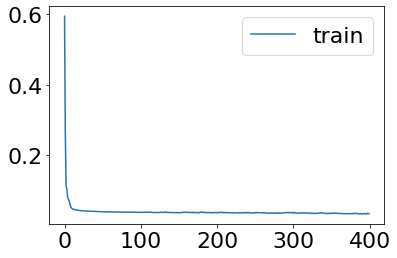

10.31906247138977


In [54]:
#2-layer RNN
start = time.time()

model = Sequential([
    SimpleRNN(30, input_shape=(train_X_copy.shape[1], train_X_copy.shape[2]), return_sequences = True),
    SimpleRNN(30),
    Dense(30, activation = "relu"),
    Dense(15, activation = "relu"),
    Dense(1)
])

model.compile(loss="mae", optimizer="adam")
history = model.fit(train_X_copy, train_y, epochs=400, batch_size=100, verbose=1, shuffle=False)
# plot history
pyplot.plot(history.history["loss"], label="train")
pyplot.legend()
pyplot.show()

print(time.time()-start)

In [55]:
# make a prediction
start = time.time()
yhat = model.predict(test_X_copy)
test_X_copy = test_X_copy.reshape(test_X_copy.shape[0], test_X_copy.shape[2])
print(time.time()-start)

0.26468873023986816


In [56]:
# invert scaling for forecast
inv_yhat = np.concatenate((test_X_copy,yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)

In [57]:
# invert scaling for actual
test_y_copy = test_y_copy.reshape((len(test_y_copy), 1))
inv_y = np.concatenate((test_X_copy,test_y_copy), axis=1)
inv_y = scaler.inverse_transform(inv_y)

In [58]:
# last element
act = [i[9] for i in inv_y] 
pred = [i[9] for i in inv_yhat] 

#Calculate MAE
print(mean_squared_error(act,pred))
print(mean_absolute_percentage_error(np.array(act),np.array(pred)))

0.17304933596682542
2.8794572761569417


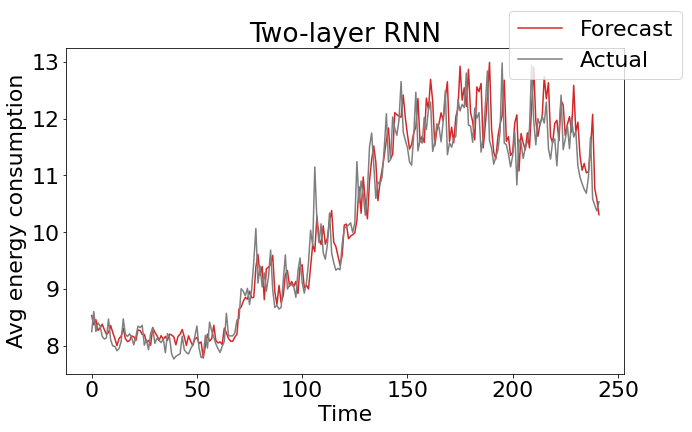

In [59]:
fig, ax1 = plt.subplots(figsize = (10,6))
ax1.plot(time_valid, pred, color = "tab:red", label = "Forecast")
ax1.plot(time_valid, act, color = "tab:grey", label = "Actual")
#ax1.set_ylim([-5,80])
ax1.set_title("Two-layer RNN")
ax1.set_ylabel("Avg energy consumption")
ax1.set_xlabel("Time")
fig.legend(loc="upper right")

In [60]:
# reshape input to be 3D [samples, timesteps, features]
train_X_copy = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X_copy = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
train_y_copy = train_y
test_y_copy = test_y
print(train_X_copy.shape,train_X.shape, train_y.shape, test_X_copy.shape, test_X.shape, test_y.shape)

(578, 1, 9) (578, 9) (578,) (242, 1, 9) (242, 9) (242,)


7/400
10/10 [==============================] - 0s 3ms/step - loss: 0.0409
Epoch 158/400
10/10 [==============================] - 0s 3ms/step - loss: 0.0409
Epoch 159/400
10/10 [==============================] - 0s 3ms/step - loss: 0.0428
Epoch 160/400
10/10 [==============================] - 0s 4ms/step - loss: 0.0404
Epoch 161/400
10/10 [==============================] - 0s 3ms/step - loss: 0.0399
Epoch 162/400
10/10 [==============================] - 0s 3ms/step - loss: 0.0403
Epoch 163/400
10/10 [==============================] - 0s 3ms/step - loss: 0.0406
Epoch 164/400
10/10 [==============================] - 0s 3ms/step - loss: 0.0400
Epoch 165/400
10/10 [==============================] - 0s 2ms/step - loss: 0.0404
Epoch 166/400
10/10 [==============================] - 0s 3ms/step - loss: 0.0412
Epoch 167/400
10/10 [==============================] - 0s 3ms/step - loss: 0.0402
Epoch 168/400
10/10 [==============================] - 0s 3ms/step - loss: 0.0410
Epoch 169/400
10/10 [===

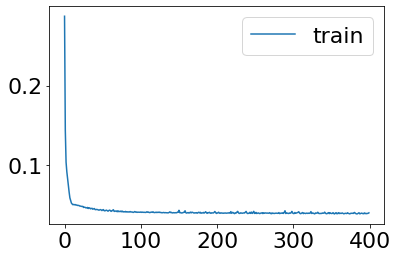

16.585909366607666


In [61]:
#1-layer LSTM
start = time.time()

model = Sequential([
    LSTM(30, input_shape=(train_X_copy.shape[1], train_X_copy.shape[2])),
    Dense(30, activation = "relu"),
    Dense(15, activation = "relu"),
    Dense(1)
])

model.compile(loss="mae", optimizer="adam")
history = model.fit(train_X_copy, train_y, epochs=400, batch_size=64, verbose=1, shuffle=False)
# plot history
pyplot.plot(history.history["loss"], label="train")
pyplot.legend()
pyplot.show()

print(time.time()-start)

In [62]:
# make a prediction
start = time.time()
yhat = model.predict(test_X_copy)
test_X_copy = test_X_copy.reshape(test_X_copy.shape[0], test_X_copy.shape[2])
print(time.time()-start)

0.40232276916503906


In [63]:
# invert scaling for forecast
inv_yhat = np.concatenate((test_X_copy,yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)

In [64]:
# invert scaling for actual
test_y_copy = test_y_copy.reshape((len(test_y_copy), 1))
inv_y = np.concatenate((test_X_copy,test_y_copy), axis=1)
inv_y = scaler.inverse_transform(inv_y)

In [65]:
# last element
act = [i[9] for i in inv_y] 
pred = [i[9] for i in inv_yhat] 

#Calculate MAE
print(mean_squared_error(act,pred))
print(mean_absolute_percentage_error(np.array(act),np.array(pred)))

0.15317877136371966
2.7562591966048524


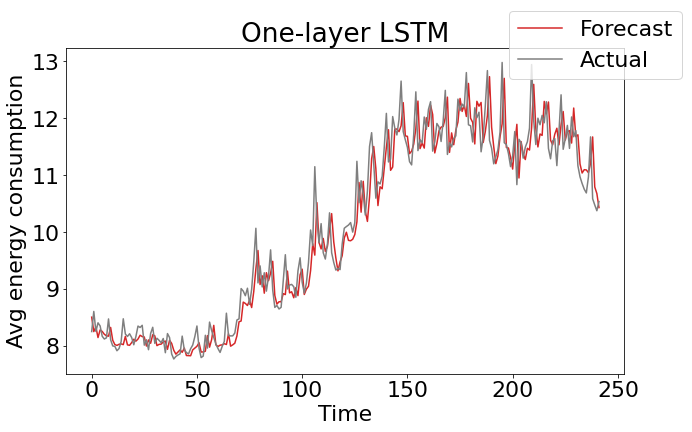

In [66]:
fig, ax1 = plt.subplots(figsize = (10,6))
ax1.plot(time_valid, pred, color = "tab:red", label = "Forecast")
ax1.plot(time_valid, act, color = "tab:grey", label = "Actual")
#ax1.set_ylim([-5,80])
ax1.set_title("One-layer LSTM")
ax1.set_ylabel("Avg energy consumption")
ax1.set_xlabel("Time")
fig.legend(loc="upper right")

In [67]:
# reshape input to be 3D [samples, timesteps, features]
train_X_copy = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X_copy = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
train_y_copy = train_y
test_y_copy = test_y
print(train_X_copy.shape,train_X.shape, train_y.shape, test_X_copy.shape, test_X.shape, test_y.shape)

(578, 1, 9) (578, 9) (578,) (242, 1, 9) (242, 9) (242,)


1/400
6/6 [==============================] - 0s 4ms/step - loss: 0.0411
Epoch 152/400
6/6 [==============================] - 0s 5ms/step - loss: 0.0406
Epoch 153/400
6/6 [==============================] - 0s 4ms/step - loss: 0.0409
Epoch 154/400
6/6 [==============================] - 0s 5ms/step - loss: 0.0412
Epoch 155/400
6/6 [==============================] - 0s 4ms/step - loss: 0.0406
Epoch 156/400
6/6 [==============================] - 0s 4ms/step - loss: 0.0405
Epoch 157/400
6/6 [==============================] - 0s 5ms/step - loss: 0.0407
Epoch 158/400
6/6 [==============================] - 0s 5ms/step - loss: 0.0410
Epoch 159/400
6/6 [==============================] - 0s 5ms/step - loss: 0.0408
Epoch 160/400
6/6 [==============================] - 0s 4ms/step - loss: 0.0404
Epoch 161/400
6/6 [==============================] - 0s 4ms/step - loss: 0.0405
Epoch 162/400
6/6 [==============================] - 0s 4ms/step - loss: 0.0407
Epoch 163/400
6/6 [=============================

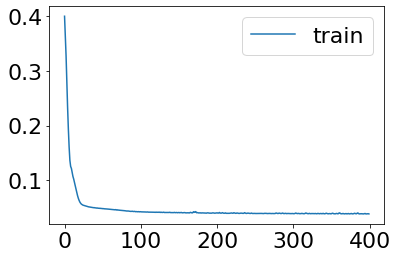

19.195823669433594


In [68]:
#Two-layer LSTM
start = time.time()

model = Sequential([
    LSTM(30, input_shape=(train_X_copy.shape[1], train_X_copy.shape[2]),return_sequences=True),
    LSTM(30),
    Dense(30, activation = "relu"),
    Dense(15, activation = "relu"),
    Dense(1)
])

model.compile(loss="mae", optimizer="adam")
history = model.fit(train_X_copy, train_y, epochs=400, batch_size=100, verbose=1, shuffle=False)
# plot history
pyplot.plot(history.history["loss"], label="train")
pyplot.legend()
pyplot.show()

print(time.time()-start)

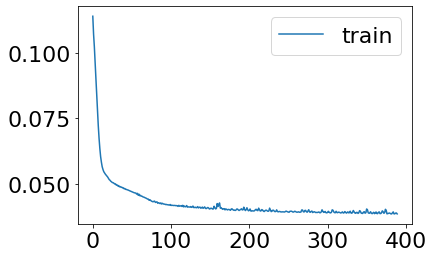

In [69]:
pyplot.plot(history.history["loss"][10:], label="train")
pyplot.legend()
pyplot.show()

In [70]:
# make a prediction
start = time.time()
yhat = model.predict(test_X_copy)
test_X_copy = test_X_copy.reshape(test_X_copy.shape[0], test_X_copy.shape[2])
print(time.time()-start)

1.2329061031341553


In [71]:
# invert scaling for forecast
inv_yhat = np.concatenate((test_X_copy,yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)

In [72]:
# invert scaling for actual
test_y_copy = test_y_copy.reshape((len(test_y_copy), 1))
inv_y = np.concatenate((test_X_copy,test_y_copy), axis=1)
inv_y = scaler.inverse_transform(inv_y)

In [73]:
# last element
act = [i[9] for i in inv_y] 
pred = [i[9] for i in inv_yhat] 

#Calculate MAE
print(mean_squared_error(act,pred))
print(mean_absolute_percentage_error(np.array(act),np.array(pred)))

0.15867019071712837
2.741761296376844


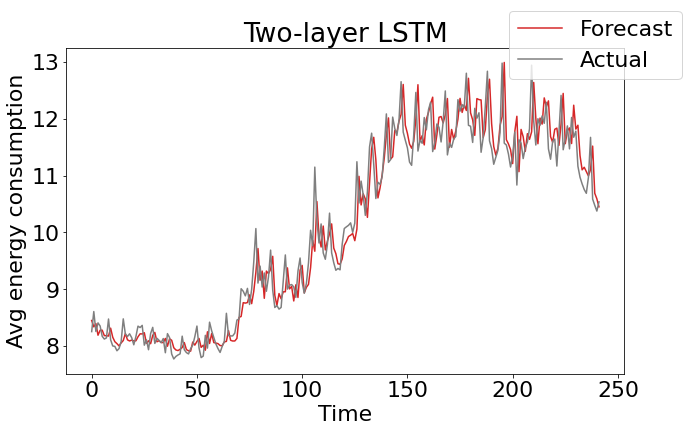

In [74]:
fig, ax1 = plt.subplots(figsize = (10,6))
ax1.plot(time_valid, pred, color = "tab:red", label = "Forecast")
ax1.plot(time_valid, act, color = "tab:grey", label = "Actual")
#ax1.set_ylim([-5,80])
ax1.set_title("Two-layer LSTM")
ax1.set_ylabel("Avg energy consumption")
ax1.set_xlabel("Time")
fig.legend(loc="upper right")

In [75]:
# reshape input to be 3D [samples, timesteps, features]
train_X_copy = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X_copy = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
train_y_copy = train_y
test_y_copy = test_y
print(train_X_copy.shape,train_X.shape, train_y.shape, test_X_copy.shape, test_X.shape, test_y.shape)

(578, 1, 9) (578, 9) (578,) (242, 1, 9) (242, 9) (242,)


Epoch 1/100
6/6 [==============================] - 0s 4ms/step - loss: 0.4034
Epoch 2/100
6/6 [==============================] - 0s 3ms/step - loss: 0.3589
Epoch 3/100
6/6 [==============================] - 0s 4ms/step - loss: 0.3085
Epoch 4/100
6/6 [==============================] - 0s 4ms/step - loss: 0.2487
Epoch 5/100
6/6 [==============================] - 0s 3ms/step - loss: 0.1939
Epoch 6/100
6/6 [==============================] - 0s 4ms/step - loss: 0.1504
Epoch 7/100
6/6 [==============================] - 0s 3ms/step - loss: 0.1218
Epoch 8/100
6/6 [==============================] - 0s 4ms/step - loss: 0.1156
Epoch 9/100
6/6 [==============================] - 0s 4ms/step - loss: 0.1104
Epoch 10/100
6/6 [==============================] - 0s 4ms/step - loss: 0.1019
Epoch 11/100
6/6 [==============================] - 0s 3ms/step - loss: 0.0967
Epoch 12/100
6/6 [==============================] - 0s 4ms/step - loss: 0.0913
Epoch 13/100
6/6 [==============================] - 0s 3ms/st

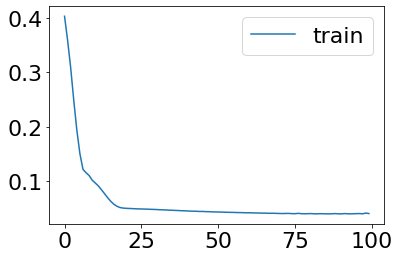

5.664647817611694


In [76]:
#CNN-LSTM-DNN
start = time.time()
model = Sequential([
    Conv1D(filters=30, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=(train_X_copy.shape[1], train_X_copy.shape[2])),
  #LSTM(30, return_sequences=True),
    LSTM(30),
    Dense(30, activation="relu"), 
    Dense(15, activation="relu"),
    Dense(1)
])

model.compile(loss="mae", optimizer="adam")
history = model.fit(train_X_copy, train_y, epochs=100, batch_size=100, verbose=1, shuffle=False)
# plot history
pyplot.plot(history.history["loss"], label="train")
pyplot.legend()
pyplot.show()

print(time.time()-start)

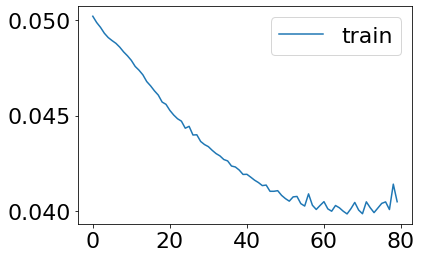

In [77]:
pyplot.plot(history.history["loss"][20:], label="train")
pyplot.legend()
pyplot.show()

In [78]:
# make a prediction
start = time.time()
yhat = model.predict(test_X_copy)
test_X_copy = test_X_copy.reshape(test_X_copy.shape[0], test_X_copy.shape[2])
print(time.time()-start)

0.5093710422515869


In [79]:
# invert scaling for forecast
inv_yhat = np.concatenate((test_X_copy,yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)

In [80]:
# invert scaling for actual
test_y_copy = test_y_copy.reshape((len(test_y_copy), 1))
inv_y = np.concatenate((test_X_copy,test_y_copy), axis=1)
inv_y = scaler.inverse_transform(inv_y)

In [81]:
# last element
act = [i[9] for i in inv_y] 
pred = [i[9] for i in inv_yhat] 

#Calculate MAE
print(mean_squared_error(act,pred))
print(mean_absolute_percentage_error(np.array(act),np.array(pred)))

0.16039114437263693
2.9082655857274475


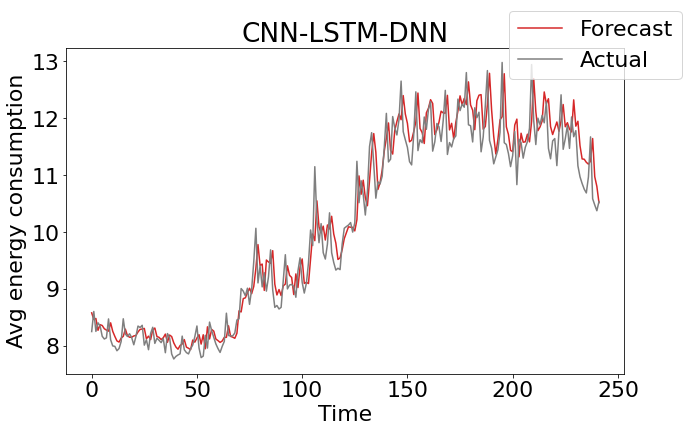

In [82]:
fig, ax1 = plt.subplots(figsize = (10,6))
ax1.plot(time_valid, pred, color = "tab:red", label = "Forecast")
ax1.plot(time_valid, act, color = "tab:grey", label = "Actual")
#ax1.set_ylim([-5,80])
ax1.set_title("CNN-LSTM-DNN")
ax1.set_ylabel("Avg energy consumption")
ax1.set_xlabel("Time")
fig.legend(loc="upper right")

In [83]:
cnnresult = pred

In [84]:
cnnresult

[8.580678450564577,
 8.464316559326946,
 8.48172214353309,
 8.273984552168272,
 8.373023816884924,
 8.358450208951894,
 8.301390983968815,
 8.277709816795252,
 8.259026551505258,
 8.40513308667444,
 8.255851993175483,
 8.16705382150947,
 8.08746660754278,
 8.06709611566881,
 8.136408124384722,
 8.168138178003808,
 8.2944506776617,
 8.177741293272447,
 8.152267111874785,
 8.151083272524396,
 8.174930554166735,
 8.181920104155765,
 8.244302026951374,
 8.290360001023103,
 8.296015591434667,
 8.307308322468614,
 8.125127471989735,
 8.171097776379781,
 8.110794773174426,
 8.28030818422694,
 8.314098774013246,
 8.164747066932676,
 8.150170207058387,
 8.111786017962935,
 8.142272768162904,
 8.207063052108097,
 8.063516723835427,
 8.190675259149714,
 8.163912379887613,
 8.05231677267657,
 7.980742076506225,
 7.941960885112643,
 8.00654988053055,
 8.033445160258175,
 8.110317069640168,
 7.978774585678686,
 7.958424070015305,
 7.933971993665033,
 8.103005511100399,
 8.06587179296806,
 8.13946348